In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm

1. Prep Work

a) $f(x) = 20 - x^2$ with interval $[a,b]$.

Then $$I=\int^b_a f(x)\,dx=\int^b_a 20-x^2\,dx=\left[20x-\frac{1}{3}x^3\right]^b_a=20(b-a) -\frac{1}{3}(b^3-a^3)$$

In [46]:
# b)
def f(x):
    return 20 - x**2

# c)
def I(a,b):
    return 20 * (b - a) - (1 / 3) * (b**3 - a**3)

2. Basic Monte Carlo

a) The expected value is approximately the integral of I that was defined earlier. In other words, $$\mathbb{E}[I_n^{\text{Basic}}] = \frac{1}{n}\left(20(b-a) - \frac{1}{3}(b^3 - a^3)\right)$$

In [47]:
# b) Fix this function

def mc_basic(f,a: float, b: float, n: int):
    ar = np.random.uniform(a,b,n)
    In = np.sum(f(ar))
    In *= (b - a)
    In *= (1 / n)
    return In, np.var(f(ar) * (b - a))

c) 

We have that $$\mathbb{E}[I_n^\text{Basic}]^2 = \frac{1}{n}\left(20(b-a)-\frac{1}{3}(b^3-a^3)\right)^2$$
Since $f^2(x) = (20-x^2)(20-x^2)=x^4-40x^2+400$ we know that $$\mathbb{E}[(I_n^\text{Basic})^2]=\frac{1}{n}\int^b_a(x^4-40x^2+400)\,dx=\frac{1}{n}\left[\frac{1}{5}x^5-\frac{40}{3}x^3+400x\right]^b_a=\frac{1}{n}\left(b^5-a^5-\frac{40}{3}(b^3-a^3)+400(b-a)\right)$$ Then $$Var(I_n^\text{Basic})=\mathbb{E}[(I_n^\text{Basic})^2]-\mathbb{E}[I_n^\text{Basic}]^2$$ $$=\frac{1}{n}\left[(b-a)\left(400(b-a)-\frac{40(b^3-a^3)}{3}+\frac{b^5-a^5}{5}\right)-\left(20(b-a)-\frac{b^3-a^3}{3}\right)^2\right]$$

In [48]:
# d) Create a function for the true variance of the basic estimator.
def mc_basic_variance_true(a: float, b: float, n: int):
    return (1 / n) * (((b - a) * (400 * (b - a) - ((40 * (b**3 - a**3)) / 3) + ((b**5 - a**5) / 5)))
                      -(20 * (b-a) - ((b**3 - a**3) / 3))**2)

# e)
n = 100000
a = -1
b = 3

#Creating dataframe
idx = np.arange(1)
df = pd.DataFrame(
    {"integral_true": I(a,b), "integral_estimate": mc_basic(f,a,b,n)[0], "difference":mc_basic(f,a,b,n)[0]-I(a,b), "sigma^2_estimate/n": mc_basic(f,a,b,n)[1], "sigma^2_estimate": mc_basic(f,a,b,n)[1]*n, "sigma^2_true/n": mc_basic_variance_true(a,b,n), "sigma^2_true": mc_basic_variance_true(a,b,n)*n}, index=idx
)
df

,integral_true,integral_estimate,difference,sigma^2_estimate/n,sigma^2_estimate,sigma^2_true/n,sigma^2_true
0,70.666667,70.660249,-0.003211,107.411657,1.084764e+07,0.001081,108.088889


3. Antithetic uniform samples

a) We have that $$\mathbb{E}^p[I^{\text{Antithetic}}_n]=I=\left(20(b-a)-\frac{1}{3}(b^3-a^3)\right)^2$$

In [49]:
# b)
def mc_antithetic(f,a: float, b: float, n: int):
    p = np.random.uniform(0,1,int(n))
    p0 = 1 - p
    x = a + (b - a) * p
    x0 = a + (b - a) * p0
    In = np.sum(f(x)) + np.sum(f(x0))
    In *= (b - a)
    In *= (1 / n) * (1 / 2)
    var = np.concatenate((f(x), f(x0))) * (b - a) / 2.0
    return In, np.var(var)

# c)
n = 100000
a = -1
b = 3
idx = np.arange(1)
df2 = pd.DataFrame(
    {"integral_true": I(a,b), "integral_estimate": mc_antithetic(f,a,b,n)[0], "difference":mc_antithetic(f,a,b,n)[0]-I(a,b), "sigma^2_estimate/n": mc_antithetic(f,a,b,n)[1], "sigma^2_estimate": mc_antithetic(f,a,b,n)[1]*n}, index=idx
)
df2

,integral_true,integral_estimate,difference,sigma^2_estimate/n,sigma^2_estimate
0,70.666667,70.66899,0.003911,26.985494,2.703967e+06


d) Using antithetic uniform samples gives a closer result to integral_true compared to using basic Monte Carlo. This is as expected, since using antithetic samples gives a negative covariance, therefore reducing the overall variance of the estimate.

4. Control Variate

a) By definition, $$\mathbb{E}[I_n^{\text{ControlVariate}}] = \mathbb{E}\left[\frac{1}{n}\sum^n_{i=1}\frac{f(x_1)-h(x_1)}{p(x_1)}\right] = I$$

In [50]:
#b)

def h1(x):
    return 20 * np.cos(x / 3)

def h2(x):
    return 20 * np.sin(x / 3)

def H1(a, b):
    int, error = quad(h1,a,b)
    return int

def H2(a,b):
    int, error = quad(h2,a,b)
    return int

# c)
def mc_control_variate(f, a: float, b: float, n: int, h, H):
    p = np.random.uniform(a,b,n)
    In = np.sum(f(p)) - np.sum(h(p))
    In *= (b - a)
    In *= (1 / n)
    In += H
    var = np.concatenate((f(p),h(p))) * (b-a) + H
    return In, np.var(var)

# d)
n = 100000
a = -1
b = 3
idx = np.arange(2)
df3 = pd.DataFrame(
    np.array([["h1","h2"], [I(a,b),I(a,b)], [mc_control_variate(f,a,b,n,h1,H1(a,b))[0],mc_control_variate(f,a,b,n,h2,H2(a,b))[0]], [mc_control_variate(f,a,b,n,h1,H1(a,b))[0] - I(a,b),mc_control_variate(f,a,b,n,h2,H2(a,b))[0] - I(a,b)], [mc_control_variate(f,a,b,n,h1,H1(a,b))[1],mc_control_variate(f,a,b,n,h2,H2(a,b))[1]], [mc_control_variate(f,a,b,n,h1,H1(a,b))[1]*n,mc_control_variate(f,a,b,n,h2,H2(a,b))[1]*n]]).T, columns = ["control_variate", "integral_true", "integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate"]
)
df3

,control_variate,integral_true,integral_estimate,difference,sigma^2_estimate/n,sigma^2_estimate
0,h1,70.66666666666667,70.66555948873122,0.0036244890489882664,112.46457309259938,11171322.756114474
1,h2,70.66666666666667,70.56270888941395,0.059346972994944736,987.3877023423742,98328404.16125694


e) The variance of h2 is significantly higher compared to h1. The difference betweeen the estimated integral and true integral is also higher for h2 compared to h1. This is shown by the below graph. Therefore, h1 is a better control variate.

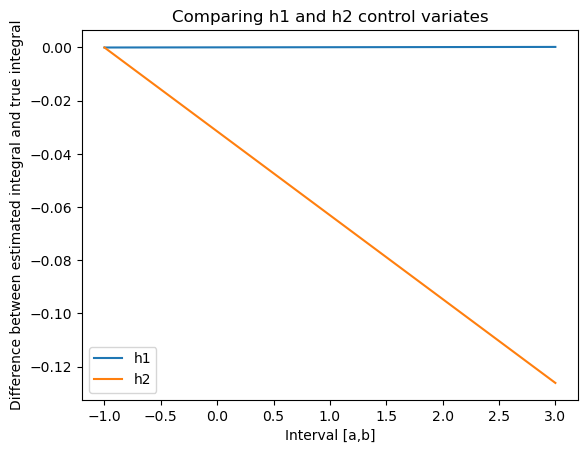

In [51]:
fig, ax = plt.subplots()
ax.plot(np.linspace(a,b),np.linspace(0,mc_control_variate(f,a,b,n,h1,H1(a,b))[0]-I(a,b)),label = 'h1')
ax.plot(np.linspace(a,b),np.linspace(0,mc_control_variate(f,a,b,n,h2,H2(a,b))[0]-I(a,b)),label = 'h2')
#ax.hlines(y = I(a,b), xmin = a, xmax = b, label = 'True integral', color = 'red', linestyles= 'dashed')
ax.set_title('Comparing h1 and h2 control variates')
ax.set_xlabel('Interval [a,b]')
ax.set_ylabel('Difference between estimated integral and true integral')
ax.legend()

f) The result for the control variates are once again very close to the true integral, but the variances are higher than I expected. The high variances suggest that using antithetic sampling is better in this case.

5. Importance Sampling

a) Similar to before, $$\mathbb{E}[I_n^{\text{Importance}}] = \mathbb{E}\left[\frac{1}{n}\sum\limits_{i=1}^{n}\frac{f(x_i)}{p(x_i)}\right] = I = 20(b-a) -\frac{1}{3}(b^3-a^3)$$

In [52]:
# b)
def mc_importance(f, a, b, n, sigma):
    p = np.random.normal(0,sigma,n)
    p0 = p[(p >= a) & (p <= b)]
    n0 = np.shape(p0)[0]
    u = norm.cdf(p0, scale = sigma)
    In = (np.sum(f(p0) / u) * (b - a)) / n
    var = np.concatenate((f(p0),u)) * (b - a)
    return In, np.var(var), n0

# c)
n = 100000
a = -1
b = 3
sigma = np.arange(1,11)
idx = np.arange(len(sigma))
num_sigma,integral_true,integral_estimate,difference,sigma2_estimate_n,sigma2_estimate,n_used = np.zeros((7,len(sigma)))
for i in range(len(sigma)):
    num_sigma[i] = sigma[i]
    integral_true[i] = I(a,b)
    integral_estimate[i] = mc_importance(f,a,b,n,sigma[i])[0]
    difference[i] = mc_importance(f,a,b,n,sigma[i])[0] - I(a,b)
    sigma2_estimate_n[i] = mc_importance(f,a,b,n,sigma[i])[1]
    sigma2_estimate[i] = mc_importance(f,a,b,n,sigma[i])[1]*n
    n_used[i] = mc_importance(f,a,b,n,sigma[i])[2]
df4 = pd.DataFrame(
    np.array([num_sigma, integral_true, integral_estimate, difference, sigma2_estimate_n, sigma2_estimate, n_used]).T, columns = ["sigma_number", "integral_true", "integral_estimate", "difference", "sigma^2_estimate/n", "sigma^2_estimate", "n_used"]
)
df4

,sigma_number,integral_true,integral_estimate,difference,sigma^2_estimate/n,sigma^2_estimate,n_used
0,1.0,70.666667,142.722630,72.466813,1412.735921,1.412105e+08,83972.0
1,2.0,70.666667,82.975461,12.890372,1296.304803,1.295796e+08,62629.0
2,3.0,70.666667,60.240000,-9.964023,1259.564250,1.258100e+08,47386.0
3,4.0,70.666667,47.642859,-22.702422,1242.352243,1.244560e+08,36983.0
4,5.0,70.666667,39.348605,-31.146527,1240.976589,1.238990e+08,30524.0
5,6.0,70.666667,33.819281,-36.868860,1232.295723,1.236769e+08,25700.0
6,7.0,70.666667,28.946073,-41.532566,1229.496559,1.231090e+08,22332.0
7,8.0,70.666667,25.946664,-44.667557,1231.095356,1.229829e+08,19519.0
8,9.0,70.666667,23.323026,-47.382576,1228.795480,1.235113e+08,17555.0
9,10.0,70.666667,21.191052,-49.524676,1232.733362,1.230154e+08,15937.0


d) The best estimators are sigma = 2 and sigma = 3, based off of the difference. However, the difference of sigma = 3 is overall lower, so it is the best estimator.

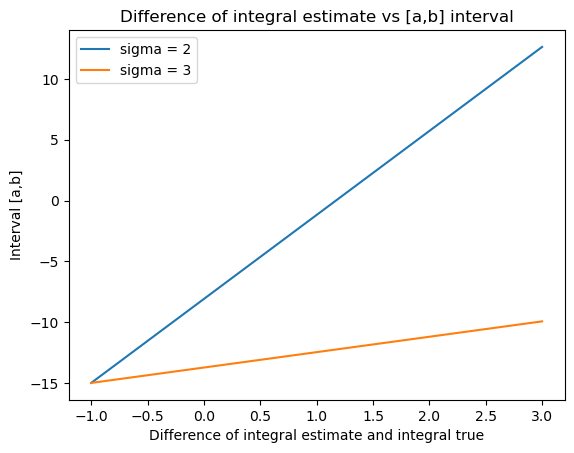

In [53]:
fig, ax = plt.subplots()
ax.plot(np.linspace(a,b), np.linspace(-15,mc_importance(f,a,b,n,sigma[1])[0] - I(a,b)),label = 'sigma = 2')
ax.plot(np.linspace(a,b), np.linspace(-15,mc_importance(f,a,b,n,sigma[2])[0] - I(a,b)),label = 'sigma = 3')
ax.set_title("Difference of integral estimate vs [a,b] interval")
ax.set_xlabel("Difference of integral estimate and integral true")
ax.set_ylabel("Interval [a,b]")
ax.legend()

e) My results compared to the basic estimate is worse. Overall, using importance sampling here did not work very well, which is not what I expected. I expected it to be more accurate compared to basic Monte Carlo.

f) As sigma increases, the number of n_used decreases. This makes sense. When we initially generate the random normal numbers, they will be more varied when our sigma increases. This means more of the numbers will be outside our desired interval, and of course the opposite will happen for smaller numbers of sigma.